In [19]:

from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score, auc, roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression

import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
df_history = pd.read_csv(r'C:\Users\jcmar\my_files\SportsBetting\data\model_results_train_v2.csv')
df_results = pd.read_csv(r'C:\Users\jcmar\my_files\SportsBetting\data\model_results_v2.csv')

df_results['pred_winner'] = np.where(df_results['correct_pred']==1, df_results['winner'], np.abs(1-df_results['winner']))
df_results['Date'] = df_results["event_dates"].copy()
df_results.sort_values(by='Date', ascending=True).reset_index(drop=True)

df_results['prob_winner'] = df_results[['red_probs','blue_probs']].max(axis=1)
df_results['winner_odds'] = np.where(df_results['winner'] == 1, df_results['open_red'], df_results['open_blue'])
df_results['choice_fighter_bet'] = np.where(df_results['pred_winner'] == 1, df_results['open_red'], df_results['open_blue'])
df_results['Date'] = df_results["Date"].astype(str)

df_correct_pred = df_results[df_results["correct_pred"] == 1].copy() 
df_incorrect_pred = df_results[df_results["correct_pred"] == 0].copy()

pred_correct_odds = df_results[df_results["correct_pred"] == 1]['choice_fighter_bet'].value_counts().sort_index()
pred_incorrect_odds = df_results[df_results["correct_pred"] == 0]['choice_fighter_bet'].value_counts().sort_index()

df_results.head()

,Unnamed: 0,blue_probs,red_probs,pred_winner,winner,correct_pred,event_dates,open_red,open_blue,close1_red,close1_blue,close2_red,close2_blue,red_fighter,blue_fighter,Date,prob_winner,winner_odds,choice_fighter_bet
0,0,0.543981,0.456019,0,0,1,2023-08-12,163.0,-200.0,164.0,-225.0,180.0,-198.0,josh parisian,martin buday,2023-08-12,0.543981,-200.0,-200.0
1,1,0.570416,0.429584,0,0,1,2023-08-12,300.0,-400.0,260.0,-450.0,350.0,-335.0,jp buys,marcus mcghee,2023-08-12,0.570416,-400.0,-400.0
2,2,0.788572,0.211428,0,0,1,2023-08-12,163.0,-200.0,158.0,-200.0,170.0,-188.0,polyana viana,iasmin lucindo,2023-08-12,0.788572,-200.0,-200.0
3,3,0.443205,0.556795,1,1,1,2023-08-12,-225.0,175.0,-200.0,140.0,-170.0,170.0,khalil rountree jr,chris daukaus,2023-08-12,0.556795,-225.0,-225.0
4,4,0.727696,0.272304,0,1,0,2023-08-12,200.0,-250.0,175.0,-320.0,250.0,-225.0,cub swanson,hakeem dawodu,2023-08-12,0.727696,200.0,-250.0


In [7]:
def plot_probabilities(df, red_col='red_probs', blue_col='blue_probs', pred_col='pred_winner', target_col='winner', bins=20, figsize=(12,5)):
 
    df = df.copy()
    df['correct'] = df[pred_col] == df[target_col]

    # --- Metrics ---
    brier_red = brier_score_loss(df[target_col], df[red_col])
    brier_blue = brier_score_loss(1 - df[target_col], df[blue_col])  # blue=0, red=1

    fig, axes = plt.subplots(2, 2, figsize=figsize, sharey=False)

    # --- Histogram for Red ---
    sns.histplot(
        data=df,
        x=red_col,
        hue='correct',
        bins=bins,
        palette={True: 'green', False: 'red'},
        alpha=0.5,
        multiple='layer',
        ax=axes[0,0]
    )
    axes[0,0].set_title(f'Red Probabilities\nBrier: {brier_red:.3f}')
    axes[0,0].set_xlabel('Red Win Probability')
    axes[0,0].set_ylabel('Count')

    # --- Histogram for Blue ---
    sns.histplot(
        data=df,
        x=blue_col,
        hue='correct',
        bins=bins,
        palette={True: 'green', False: 'red'},
        alpha=0.5,
        multiple='layer',
        ax=axes[0,1]
    )
    axes[0,1].set_title(f'Blue Probabilities\nBrier: {brier_blue:.3f}')
    axes[0,1].set_xlabel('Blue Win Probability')
    axes[0,1].set_ylabel('Count')

    # --- Calibration curve for Red ---
    prob_true_red, prob_pred_red = calibration_curve(df[target_col], df[red_col], n_bins=20)
    axes[1,0].plot(prob_pred_red, prob_true_red, "s-", label="Empirical")
    axes[1,0].plot([0,1], [0,1], "k--", label="Perfectly Calibrated")
    axes[1,0].set_title("Calibration: Red")
    axes[1,0].set_xlabel("Predicted probability")
    axes[1,0].set_ylabel("Observed frequency")
    axes[1,0].legend()

    # --- Calibration curve for Blue ---
    # Flip labels: blue win = 1 - target_col
    prob_true_blue, prob_pred_blue = calibration_curve(1 - df[target_col], df[blue_col], n_bins=10)
    axes[1,1].plot(prob_pred_blue, prob_true_blue, "s-", label="Empirical")
    axes[1,1].plot([0,1], [0,1], "k--", label="Perfectly Calibrated")
    axes[1,1].set_title("Calibration: Blue")
    axes[1,1].set_xlabel("Predicted probability")
    axes[1,1].set_ylabel("Observed frequency")
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()

In [26]:
def calibrate_probs(
    df_train, df_test,
    target_col='winner',
    red_model_col='red_probs',
    blue_model_col='blue_probs',
    red_odds_col='dec_red',
    blue_odds_col='dec_blue',
    frac_calib_input=0.15,
    random_state=42
):
    """
    Calibrate predicted probabilities using sigmoid (Platt) calibration.
    Returns metrics and calibrated dataframe.
    """

    # --- Split calibration input ---
    n = len(df_train)
    n_input = int(np.round(n * frac_calib_input))
    n_main = n - n_input
    if n_main <= 0:
        raise ValueError("Not enough training data; reduce calibration fraction.")

    train_main_df = df_train.iloc[:n_main].reset_index(drop=True)
    calib_df = df_train.iloc[n_main:].reset_index(drop=True)

    # --- Prepare arrays ---
    X_calib = calib_df[[red_model_col, blue_model_col]].values
    y_calib = calib_df[target_col].astype(int).values
    X_test = df_test[[red_model_col, blue_model_col]].values
    y_test = df_test[target_col].astype(int).values

    # --- Fit sigmoid calibrator ---
    base_model = LogisticRegression(max_iter=5000, random_state=random_state)
    calibrator = CalibratedClassifierCV(base_model, method='sigmoid', cv='prefit')

    # Fit on calibration data
    base_model.fit(X_calib, y_calib)  # prefit
    calibrator.fit(X_calib, y_calib)

    # --- Predict calibrated probabilities ---
    calibrated_probs = calibrator.predict_proba(X_test)  # shape: (n_samples, 2)
    red_calib = calibrated_probs[:, 1]
    blue_calib = calibrated_probs[:, 0]

    # --- Normalize to sum to 1 ---
    total = red_calib + blue_calib
    red_calib /= total
    blue_calib /= total

    # --- Predicted winner ---
    y_pred = (red_calib >= blue_calib).astype(int)

    # --- Metrics ---
    metrics = {
        "Brier_Raw": brier_score_loss(y_test, df_test[red_model_col].values),
        "Brier_Calibrated": brier_score_loss(y_test, red_calib),
        "LogLoss_Raw": log_loss(y_test, df_test[red_model_col].values),
        "LogLoss_Calibrated": log_loss(y_test, red_calib),
        "AUC_Raw": roc_auc_score(y_test, df_test[red_model_col].values),
        "AUC_Calibrated": roc_auc_score(y_test, red_calib),
    }

    # --- Build calibrated dataframe ---
    df_calib = pd.DataFrame({
        'pred_winner': y_pred,
        'red_probs': red_calib,
        'blue_probs': blue_calib,
        'dec_red': df_test[red_odds_col].values,
        'dec_blue': df_test[blue_odds_col].values,
        'winner': df_test[target_col].values
    })

    return metrics, df_calib
def american_to_decimal(odds):
    return np.where(odds > 0, odds / 100 + 1, 100 / np.abs(odds) + 1)

metrics, df_calib = calibrate_probs(df_history, df_results,red_odds_col='dec_open_red',
     blue_odds_col='dec_open_blue',)
metrics


c:\Users\jcmar\my_files\SportsBetting\venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


{'Brier_Raw': np.float64(0.2095768320078167),
 'Brier_Calibrated': np.float64(0.2096940196718513),
 'LogLoss_Raw': 0.6063341687310277,
 'LogLoss_Calibrated': 0.607705833312514,
 'AUC_Raw': np.float64(0.7315610892256378),
 'AUC_Calibrated': np.float64(0.7315610892256378)}

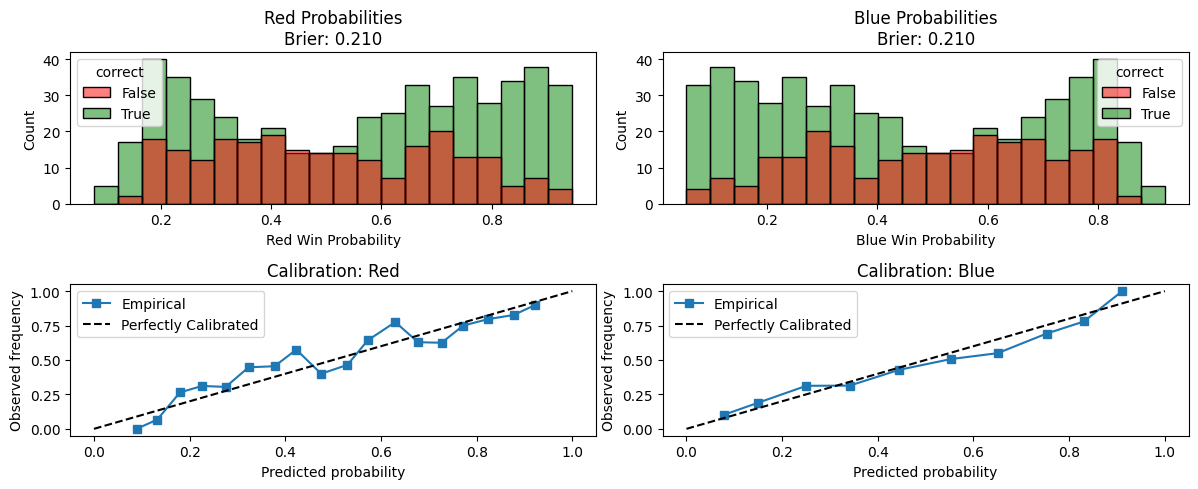

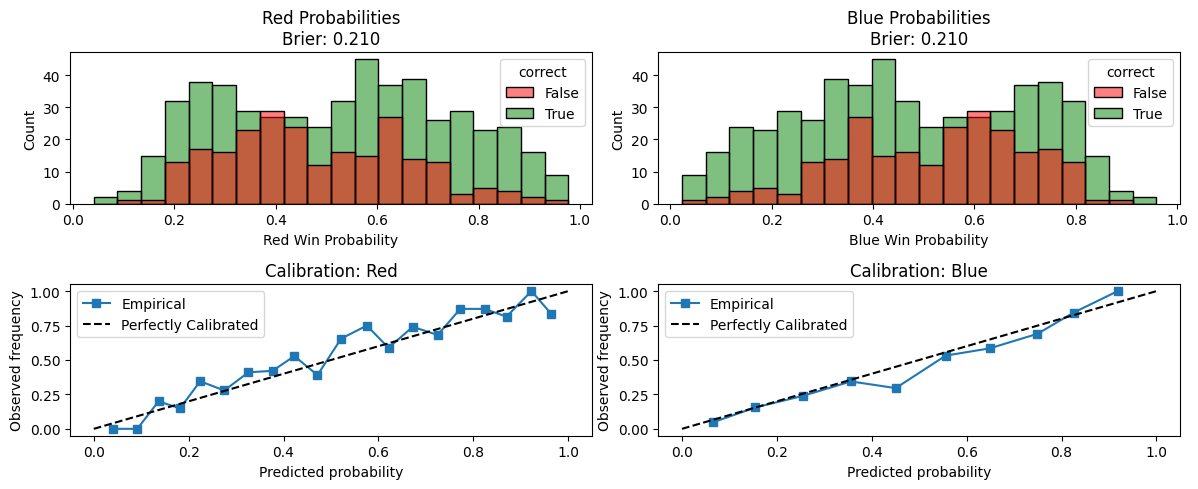

In [27]:
plot_probabilities(df_calib)
plot_probabilities(df_results)